In [1]:
from bs4 import BeautifulSoup
import requests
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import numpy
import json

sns.set_context('talk')
sns.set_style('whitegrid')
%matplotlib notebook

In [2]:
class RunMeta(object):
    
    def __init__(self, js):
        self.js = js
        
    def dump(self):
        return json.dumps(self.js, 
                          sort_keys=True, 
                          indent=4, 
                          separators=(',', ': '))

    def run_number(self):
        return self.js['record']['cycle']['run']
        

class RunCat(object):
    logger = logging.getLogger("runcat")
    
    def __init__(self):
        self._latest_ = None
        self._reference_ = None
    
    @property
    def latest(self):
        if self._latest_ is None:
            self.get_latest()
        return self._latest_
    
    @property
    def reference(self):
        if self._reference_ is None:
            self.get_reference(self.latest)
        return self._reference_        
        
    
    def get_latest(self):
        r = requests.get("http://ubdaq-prod-near2.fnal.gov/RunCat/data/latest.txt")
        self._latest_ = int(r.text)
    
    def get_run_info(self, run_n):
        url = 'http://ubdaq-prod-near2.fnal.gov/RunCat/data/run_{}.json'.format(str(run_n).zfill(8))
        return RunMeta(requests.get(url).json())
    
    def get_serve_hists(self, run_n, hists='HLIST'):
        payload = {'run': '{}'.format(run_n),
                   'hists': hists,
                   'options': ':maxListDepth2:'
                   }
        url = "http://ubdaq-prod-near2.fnal.gov/Lizard/{}/server/serve_hists.cgi".format(run_n)
        return requests.post(url, data=payload)
    
    def get_reference(self, run_n):
        payload={'filename':'reference.root','hists':'','options':':maxListDepth2:'}
        url = "http://ubdaq-prod-near2.fnal.gov/Lizard/{}/server/serve_hists.cgi".format(run_n)
        self._reference_= int(json.loads(requests.post(url, data=payload).text)['record']['cycle']['run'])

In [3]:
rc = RunCat()
print rc.reference
print rc.get_run_info(rc.latest).dump()

10849
{
    "header": {
        "num_events": 0,
        "run": 12366,
        "start": "2017-08-14T17:03:14.961550+00:00",
        "stop": "2017-08-14T19:10:35.859165+00:00"
    },
    "run_data": {
        "SN": {
            "seb01": {
                "data_size": 54380000268,
                "end": "2017-08-14T19:11:12.351837+00:00",
                "live_time": 7676.338912000001,
                "seb": "seb01",
                "start": "2017-08-14T17:03:15.672944+00:00"
            },
            "seb02": {
                "data_size": 76796000380,
                "end": "2017-08-14T19:11:12.293165+00:00",
                "live_time": 7675.886278000002,
                "seb": "seb02",
                "start": "2017-08-14T17:03:15.381941+00:00"
            },
            "seb03": {
                "data_size": 100660000500,
                "end": "2017-08-14T19:11:12.421196+00:00",
                "live_time": 7675.962445999999,
                "seb": "seb03",
                "star

In [4]:
print json.dumps(json.loads(rc.get_serve_hists(rc.latest-1).text), sort_keys=True, indent=4, separators=(',', ': '))

{
    "record": {
        "cycle": {
            "event": "",
            "filename": "/datalocal/om/run_00012365.om.root",
            "firstEventTime": 1502725322136.89,
            "lastEventTime": 1502729970710.79,
            "run": "12365",
            "subrun": "79",
            "updateTime": 1502730021974.45
        },
        "shipment": {
            "HLIST": "<ul class='om_subdirlist' data-ompath='/'><li class='om-dir' data-ompath='/headers/'><a href='#/headers' class='om-dir-title' data-ompath='/headers/'>headers</a><ul class='om_subdirlist' data-ompath='/headers/'><li><a href='#/headers/h_crate_event_numbers_vs_global' class='om-elem root-TH2F' data-roottype='TH2F' data-ompath='/headers/h_crate_event_numbers_vs_global'>h_crate_event_numbers_vs_global</a></li><li><a href='#/headers/h_crate_event_numbers_vs_trig' class='om-elem root-TH2F' data-roottype='TH2F' data-ompath='/headers/h_crate_event_numbers_vs_trig'>h_crate_event_numbers_vs_trig</a></li><li><a href='#/headers/h_c

In [5]:
print rc.get_serve_hists(rc.latest-1, hists='/tpc/plane2/h_54_pulseheight_vs_walltime:/errors/h_data_errors').text

{"record":{"cycle":{"filename":"\/datalocal\/om\/run_00012365.om.root","updateTime":1502730021974.45,"firstEventTime":1502725322136.89,"lastEventTime":1502729970710.79,"run":"12365","subrun":"79","event":""},"warning":"Could not find path \/errors","shipment":{"/tpc/plane2/h_54_pulseheight_vs_walltime":{"name":"h_54_pulseheight_vs_walltime","title":"Plane 2 (Collection) - Average pulse height vs wall time","classname":"TProfile","xlabel":"Wall Time","ylabel":"Average pulse height","n":128,"min":1502725322.0000000000,"max":1502733002.0000000000,"underflow":0.00,"overflow":0.00,"total":1522725.000000000,"sum_x":2288241260518180.000000000,"sum_x2":3438603862359164397289472.000000000,"max_content":77.3399,"min_content":0.0000,"time_on_x":true,"data":[66.12,0,0,0,0,0,70.3,0,72.59,67.88,64.86,0,0,61.5,73.4,67.52,67.25,0,0,56.74,0,71.32,65.09,66.92,0,67.88,68.66,71.51,65.42,0,72.82,54.03,67.55,74.41,0,0,0,73.04,73.32,69.95,69.62,0,0,69.44,0,68.71,69.04,64.84,0,67.6,69.67,65.92,66.74,0,0,71.09

<IPython.core.display.Javascript object>


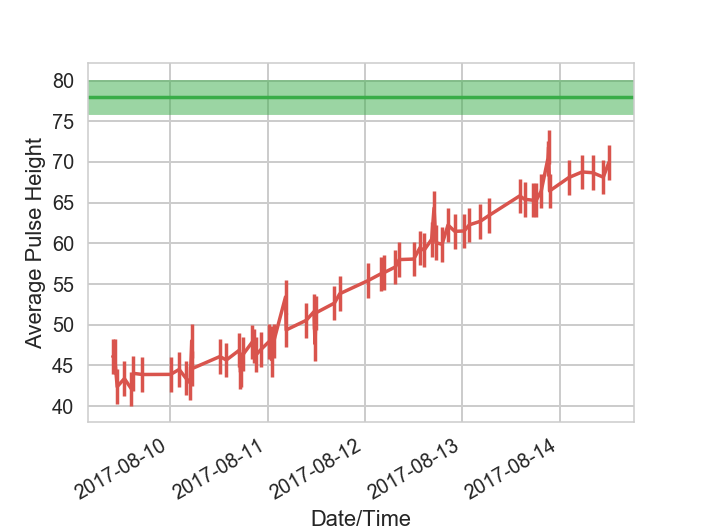

In [7]:
ref_dat = json.loads(rc.get_serve_hists(rc.reference, hists='/tpc/plane2/h_54_pulseheight_vs_walltime:/errors/h_data_errors').text)
ref_y = ref_dat['record']['shipment']["/tpc/plane2/h_54_pulseheight_vs_walltime"]['data']
valid_y = [int(i) for i in ref_y if i>0]

ref_y_ave = sum(valid_y)/len(valid_y)
ref_y_std = np.std(valid_y)/2.0

x=[]
y=[]
y_err=[]
for i in range(95):
    
    try:
        latest_dat = json.loads(rc.get_serve_hists(rc.latest-i, 
                                                   hists='/tpc/plane2/h_54_pulseheight_vs_walltime:/errors/h_data_errors').text)
        latest_y = latest_dat['record']['shipment']["/tpc/plane2/h_54_pulseheight_vs_walltime"]['data']
        valid_y = [float(i) for i in latest_y if i>0.0]
        latest_y_ave = sum(valid_y)/len(valid_y)
        latest_y_err = np.std(valid_y)
        latest_x = latest_dat['record']['cycle']['firstEventTime']
        latest_x = datetime.datetime.fromtimestamp(latest_x/1000)
        x.append(latest_x)
        y.append(latest_y_ave)
    except:
        continue

ax = plt.figure()
plt.errorbar(x,y,yerr=latest_y_err, color=sns.xkcd_rgb["pale red"])
plt.axhspan(ref_y_ave-ref_y_std, ref_y_ave+ref_y_std, alpha=0.5, color=sns.xkcd_rgb["medium green"])
plt.axhline(y=ref_y_ave, hold=None, color=sns.xkcd_rgb["medium green"])
plt.xlabel('Date/Time')
plt.ylabel('Average Pulse Height')
plt.tight_layout()
ax.autofmt_xdate()
plt.show()
plt.savefig("purity.png")

<IPython.core.display.Javascript object>


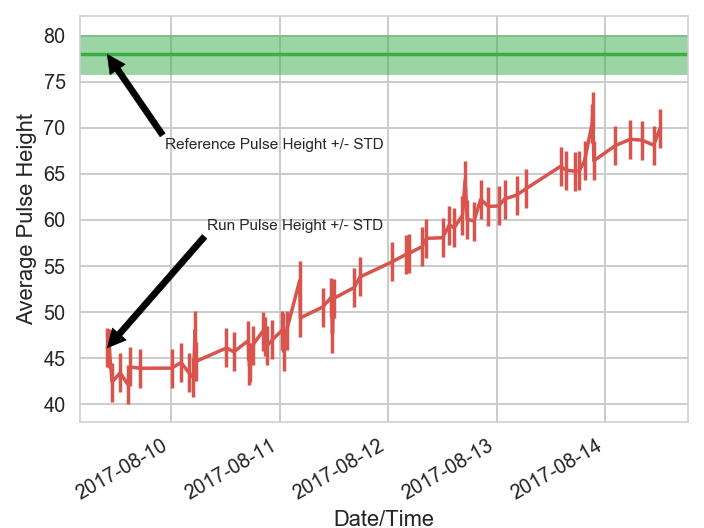

In [29]:
ax = plt.figure()
plt.errorbar(x,y,yerr=latest_y_err, color=sns.xkcd_rgb["pale red"])
plt.axhspan(ref_y_ave-ref_y_std, ref_y_ave+ref_y_std, alpha=0.5, color=sns.xkcd_rgb["medium green"])
plt.axhline(y=ref_y_ave, hold=None, color=sns.xkcd_rgb["medium green"])
plt.xlabel('Date/Time')
plt.ylabel('Average Pulse Height')

plt.annotate('Reference Pulse Height +/- STD', xy=(latest_x,ref_y_ave ),  xycoords='data',
            xytext=(0.5, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.001),
            horizontalalignment='right', verticalalignment='top',
            )

plt.annotate('Run Pulse Height +/- STD', xy=(latest_x,latest_y_ave  ),  xycoords='data',
            xytext=(0.5, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.001),
            horizontalalignment='right', verticalalignment='top',
            )



plt.tight_layout()
ax.autofmt_xdate()
plt.show()
plt.savefig("purity_annotated.png")